#### Group Information

Group No: Climate2

- Member 1: Ng Xuan Hern 22304061
- Member 2: Lim Wei Ling 22306277
- Member 3: Lim Yi Jie 22304136
- Member 4: Joanne Loi Jin Xu 22303573

### Import libraries

In [1]:
import pandas as pd
import numpy as np

# plot graph
import matplotlib.pyplot as plt
import seaborn as sns

#sklearn module
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.compose import ColumnTransformer
from sklearn.utils import shuffle # use for randomize the data before splitting it into training and testing
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score, recall_score, f1_score, fbeta_score, confusion_matrix, classification_report

# building neural network models
from tensorflow import keras
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop # optimization algorithms used for training the model
from tensorflow.keras.losses import BinaryCrossentropy # used for loss function used for binary classification tasks
from tensorflow.keras.metrics import FBetaScore # used for evaluating precision-recall trade-offs, useful for imbalanced datasets
from scikeras.wrappers import KerasClassifier
from imblearn.over_sampling import SMOTE # for oversampling
from collections import Counter

# fuzzy library
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import itertools  # used in generate fuzzy rules

import warnings
warnings.filterwarnings('ignore')

### Load the dataset

In [2]:
df = pd.read_csv("Climate Model Simulation/climate.csv") 

### Exploratory Data Analysis (EDA)

In [3]:
# check the first few entries in the dataset
df.head()

,Study,Run,vconst_corr,vconst_2,vconst_3,vconst_4,vconst_5,vconst_7,ah_corr,ah_bolus,...,efficiency_factor,tidal_mix_max,vertical_decay_scale,convect_corr,bckgrnd_vdc1,bckgrnd_vdc_ban,bckgrnd_vdc_eq,bckgrnd_vdc_psim,Prandtl,outcome
0,1,1,0.859036,0.927825,0.252866,0.298838,0.170521,0.735936,0.428325,0.567947,...,0.245675,0.104226,0.869091,0.997518,0.448620,0.307522,0.858310,0.796997,0.869893,0
1,1,2,0.606041,0.457728,0.359448,0.306957,0.843331,0.934851,0.444572,0.828015,...,0.616870,0.975786,0.914344,0.845247,0.864152,0.346713,0.356573,0.438447,0.512256,1
2,1,3,0.997600,0.373238,0.517399,0.504993,0.618903,0.605571,0.746225,0.195928,...,0.679355,0.803413,0.643995,0.718441,0.924775,0.315371,0.250642,0.285636,0.365858,1
3,1,4,0.783408,0.104055,0.197533,0.421837,0.742056,0.490828,0.005525,0.392123,...,0.471463,0.597879,0.761659,0.362751,0.912819,0.977971,0.845921,0.699431,0.475987,1
4,1,5,0.406250,0.513199,0.061812,0.635837,0.844798,0.441502,0.191926,0.487546,...,0.551543,0.743877,0.312349,0.650223,0.522261,0.043545,0.376660,0.280098,0.132283,1


By looking at the first few rows of the dataset, we can see that the dataset contains engineered features or physical model parameters. 

The target column 'outcome', which seems binary, suitable for classification tasks.

Continuous features <br>
|-- discrete: Study, Run, outcome <br>
|-- continuous: vconst_corr, vconst_2, vconst_3, vconst_4, vconst_5,vconst_7,ah_corr, ah_bolus, slm_corr, efficiency_factor, tidal_mix_max, vertical_decay_scale, convect_corr, bckgrnd_vdc1, bckgrnd_vdc_ban, bckgrnd_vdc_eq, bckgrnd_vdc_psim, Prandtl! <br>

In [4]:
# check a summary of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540 entries, 0 to 539
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Study                 540 non-null    int64  
 1   Run                   540 non-null    int64  
 2   vconst_corr           540 non-null    float64
 3   vconst_2              540 non-null    float64
 4   vconst_3              540 non-null    float64
 5   vconst_4              540 non-null    float64
 6   vconst_5              540 non-null    float64
 7   vconst_7              540 non-null    float64
 8   ah_corr               540 non-null    float64
 9   ah_bolus              540 non-null    float64
 10  slm_corr              540 non-null    float64
 11  efficiency_factor     540 non-null    float64
 12  tidal_mix_max         540 non-null    float64
 13  vertical_decay_scale  540 non-null    float64
 14  convect_corr          540 non-null    float64
 15  bckgrnd_vdc1          5

In [5]:
# Check for missing values in each column of the dataset
df.isnull().sum()

Study                   0
Run                     0
vconst_corr             0
vconst_2                0
vconst_3                0
vconst_4                0
vconst_5                0
vconst_7                0
ah_corr                 0
ah_bolus                0
slm_corr                0
efficiency_factor       0
tidal_mix_max           0
vertical_decay_scale    0
convect_corr            0
bckgrnd_vdc1            0
bckgrnd_vdc_ban         0
bckgrnd_vdc_eq          0
bckgrnd_vdc_psim        0
Prandtl                 0
outcome                 0
dtype: int64

In [6]:
# check the number of rows and columns in the dataset
df.shape

(540, 21)

In [7]:
# check the names of all the columns in the dataset
col_names = df.columns
col_names

Index(['Study', 'Run', 'vconst_corr', 'vconst_2', 'vconst_3', 'vconst_4',
       'vconst_5', 'vconst_7', 'ah_corr', 'ah_bolus', 'slm_corr',
       'efficiency_factor', 'tidal_mix_max', 'vertical_decay_scale',
       'convect_corr', 'bckgrnd_vdc1', 'bckgrnd_vdc_ban', 'bckgrnd_vdc_eq',
       'bckgrnd_vdc_psim', 'Prandtl', 'outcome'],
      dtype='object')

In [8]:
# Set the target variable to 'outcome' which we want to predict
target = 'outcome'

In [9]:
#view the distribution of the the target variable
df[target].value_counts()

outcome
1    494
0     46
Name: count, dtype: int64

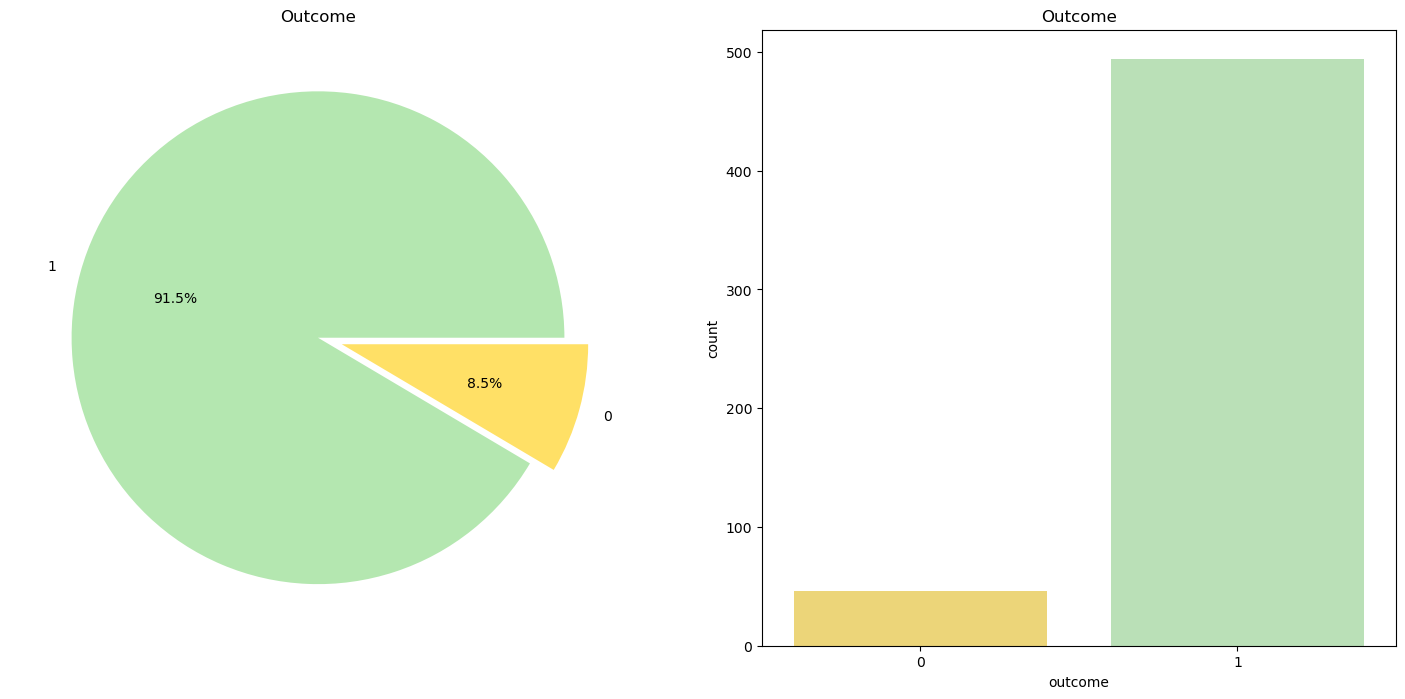

In [10]:
# visualize the distribution of the target variable
# Plot the distribution of the target variable
f, ax = plt.subplots(1, 2, figsize=(18, 8))

# Pie chart
df[target].value_counts().plot.pie(
    explode=[0, 0.1], 
    autopct='%1.1f%%', 
    ax=ax[0], 
    shadow=False,
    colors=['#b4e7b0', '#ffe066'] 
)
ax[0].set_title('Outcome')
ax[0].set_ylabel('')

# Count plot
sns.countplot(x=target, data=df, ax=ax[1],  palette=['#ffe066','#b4e7b0'])
ax[1].set_title('Outcome')
plt.show()

Out of all the 540 rows, we can see that only around 50 (8.5%) of the rows is of value "0". Therefore, this is a highly imbalanced dataset. We will need to address this issue by performing oversampling in the preprocessing step. 

### Correlation Matrix

In [11]:
numerical_features = df.select_dtypes(include='number')
df_corr = numerical_features.corr()

In [12]:
df_corr

,Study,Run,vconst_corr,vconst_2,vconst_3,vconst_4,vconst_5,vconst_7,ah_corr,ah_bolus,...,efficiency_factor,tidal_mix_max,vertical_decay_scale,convect_corr,bckgrnd_vdc1,bckgrnd_vdc_ban,bckgrnd_vdc_eq,bckgrnd_vdc_psim,Prandtl,outcome
Study,1.000000e+00,1.033701e-15,-0.000397,0.000307,-0.000521,0.000242,-0.000086,-0.000431,0.000254,0.000051,...,0.000391,-0.000052,-0.000105,-0.000225,0.000544,-0.000124,-9.020903e-07,-0.000280,0.000180,0.048748
Run,1.033701e-15,1.000000e+00,-0.034414,-0.058644,-0.018387,-0.021134,-0.042972,-0.040134,-0.039149,-0.094475,...,0.080217,-0.003172,-0.048443,-0.068251,-0.047611,0.045694,-1.059208e-01,-0.014953,0.039661,-0.013916
vconst_corr,-3.970866e-04,-3.441408e-02,1.000000,0.004039,0.009331,-0.018294,0.018880,0.001544,0.003714,-0.012735,...,0.010617,-0.014205,-0.008992,-0.002980,-0.002133,-0.002099,1.597279e-02,-0.016631,-0.001467,-0.304787
vconst_2,3.067567e-04,-5.864436e-02,0.004039,1.000000,-0.000456,-0.000614,-0.008292,-0.024379,-0.005182,0.004179,...,-0.011072,0.019706,0.001623,0.002608,-0.014716,0.004386,5.998563e-03,0.004202,0.009141,-0.302388
vconst_3,-5.213985e-04,-1.838657e-02,0.009331,-0.000456,1.000000,0.009899,0.006289,-0.001587,0.019941,0.004402,...,0.007100,-0.009428,-0.024702,-0.020637,-0.004264,-0.005210,-5.588026e-04,0.004771,-0.001334,0.000227
vconst_4,2.424574e-04,-2.113392e-02,-0.018294,-0.000614,0.009899,1.000000,0.020504,0.021931,0.001805,-0.002334,...,-0.004753,0.018320,-0.010004,-0.006762,0.020442,-0.001080,-9.261710e-03,-0.017147,0.005053,0.072297
vconst_5,-8.609085e-05,-4.297164e-02,0.018880,-0.008292,0.006289,0.020504,1.000000,0.005887,-0.003047,0.012453,...,0.001077,0.021354,-0.016312,0.021380,0.009894,-0.019179,-2.075219e-02,-0.009324,0.012265,0.054390
vconst_7,-4.308863e-04,-4.013435e-02,0.001544,-0.024379,-0.001587,0.021931,0.005887,1.000000,-0.016770,-0.021644,...,0.015121,0.000075,0.015288,0.007036,-0.003641,-0.007897,-6.575539e-03,0.013203,0.008412,0.048646
ah_corr,2.542364e-04,-3.914892e-02,0.003714,-0.005182,0.019941,0.001805,-0.003047,-0.016770,1.000000,-0.035498,...,0.009604,-0.006832,0.016503,0.002921,0.012447,-0.003368,7.050740e-03,0.002443,-0.002381,0.017049
ah_bolus,5.095781e-05,-9.447464e-02,-0.012735,0.004179,0.004402,-0.002334,0.012453,-0.021644,-0.035498,1.000000,...,0.012260,0.012005,-0.003947,-0.019307,-0.010642,0.004866,3.239789e-02,0.000259,0.007055,0.003895


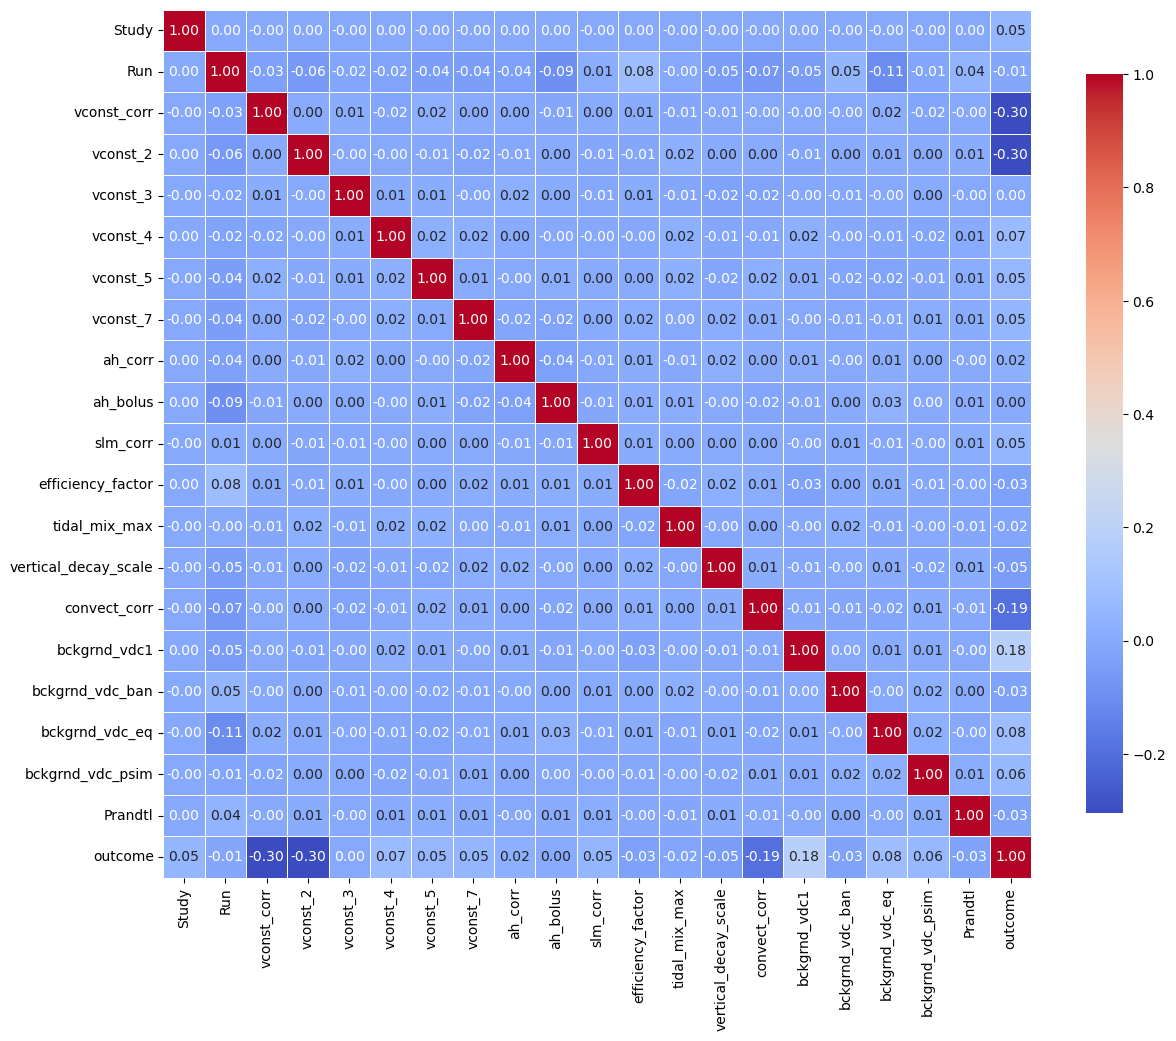

In [13]:
# check correlation between variables
plt.figure(figsize=(14, 12))
sns.heatmap(df_corr, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=.5, cbar_kws={"shrink": .8})
plt.show()

From the correlation matrix, we observe that: 
All of the features have weak linear relationships with each other.
Most features have very weak linear correlations with the target variable (correlation coefficients close to 0 or even negative value.)

The highest absolute correlation is only aroung 0.18, indicating a low linear dependency. 
Therefore, the correlation matrix doesn't reveal strong predictive relationships between the numerical features and the target. 

### Correlation Matrix with Target Variable "outcome"

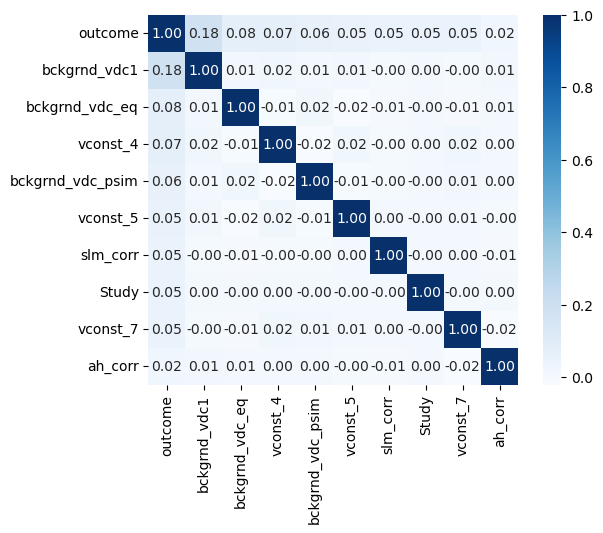

In [14]:
# Select top k features most correlated with the target and plot their correlation matrix
k = 10
cols = df_corr.nlargest(k, 'outcome')['outcome'].index
cm = np.corrcoef(df[cols].values.T)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values, cmap=plt.cm.Blues)
plt.show()

Weak linear correlations between taget variable and other features. 
The highest correlation is the feature "bckgrnd_vdc1" (0.18).
The rest of the features have a correlation of less than 0.1. 

### Handle Duplicate Data

In [15]:
# Get all occurrences of duplicate rows including the first occurrence
all_duplicate_rows = df[df.duplicated(keep=False)]
print("All duplicate rows (including first occurrence):")
print(all_duplicate_rows)

All duplicate rows (including first occurrence):
Empty DataFrame
Columns: [Study, Run, vconst_corr, vconst_2, vconst_3, vconst_4, vconst_5, vconst_7, ah_corr, ah_bolus, slm_corr, efficiency_factor, tidal_mix_max, vertical_decay_scale, convect_corr, bckgrnd_vdc1, bckgrnd_vdc_ban, bckgrnd_vdc_eq, bckgrnd_vdc_psim, Prandtl, outcome]
Index: []

[0 rows x 21 columns]


No duplicated rows to be remove. 

### Split the dataset

In [16]:
X = df.drop(columns=['Run','Study','outcome'])
y = df['outcome']

seed_num = 10

# Split the dataset into 70% training and 30% temporary data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=seed_num)

# Second split into 10% validation and 20% test data
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=(2/3), random_state=seed_num)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

Training set: (378, 18)
Validation set: (54, 18)
Test set: (108, 18)


## Model 1: Feedforward Neural Network

### Data preprocessing
Perform data preprocessing such as normalization, standardization, label encoding etc.
______________________________
Description: <br>
Firstly, we saved feature names before the standardization to preserve the columns names for later feature selection purpose. Next, we initialise a StandardScaler to carry out standardization. The StandardScaler was only fitted on the training data to compute its mean and standard deviation. This is crucial to prevent data leakage. The learned mean and standard deviation were then used to transform the validation and test data to ensure all datasets are standardized in the same way. No label encoding was carried out because all features are already numerical.

In [17]:
# Store feature names before converting to NumPy arrays (for interpretability)
feature_names = X.columns.tolist()

# Create an instance of the StandardScaler
scaler = StandardScaler()

# fit standard scaler on training data only to learn from it
X_train = scaler.fit_transform(X_train) 

# apply same transformation to validation and test data using training scaler 
X_val = scaler.transform(X_val)   
X_test = scaler.transform(X_test)

### Oversampling
To do this, we will use the SMOTE technique to oversample the minority class of training sample. Test and validation set are not oversampled because these sets are ought to remain realistic. Artificially balancing these sets would not be a good idea as it will bear no real relation to the real world problem we are trying to solve.

In [18]:
# balance the dataset by oversampling the minority class
smote = SMOTE(random_state=seed_num, sampling_strategy='minority')

# fit predictor and target variable
X_smote, y_smote = smote.fit_resample(X_train, y_train)

print('Original dataset shape', Counter(y))  # Original class distribution before oversampling
print('Resample dataset shape', Counter(y_smote)) # Class distribution after oversampling

# Update the training data with the resampled data
X_train = X_smote
y_train = y_smote

Original dataset shape Counter({1: 494, 0: 46})
Resample dataset shape Counter({1: 345, 0: 345})


### Define Base Model

In [19]:
# Define a neural network model with customizable hyperparameters
def define_model(neurons=10, dropout_rate=0.0, activation='relu', init_weights="uniform", 
                 optimizer='Adam', learning_rate=0.0001, momentum=0.1):
    """
    Builds and compiles a customizable binary classification neural network.

    Input parameters:
    -----------------
    - neurons: int
        Number of neurons in the hidden layer.
    - dropout_rate: float
        Dropout rate to prevent overfitting.
    - activation: str
        Activation function for the hidden layer.
    - init_weights: str
        Weight initializer for dense layers.
    - optimizer: str
        Optimizer name: 'SGD', 'RMSprop', or 'Adam'.
    - learning_rate: float
        Learning rate for the optimizer.
    - momentum: float
        Momentum parameter (used only with SGD).

    Returns:
    --------
    - model: keras.Model
        A compiled Keras model ready for training.
    """
    print("All parameters:", dropout_rate, neurons, activation, init_weights, optimizer, learning_rate, momentum)

    model = Sequential()
    
    # Explicit input layer, specifying the input shape based on the training data
    model.add(Input(shape=(X_train.shape[-1],), name='InputLayer'))

    # Add a dense hidden layer with customizable neurons and activation function
    model.add(Dense(neurons, activation=activation, kernel_initializer=init_weights, name='HiddenLayer'))
    
    # Add dropout layer to prevent overfitting by randomly setting a fraction of inputs to zero
    model.add(Dropout(dropout_rate, name='DropoutLayer'))
    
    # Output layer with sigmoid activation for binary classification
    model.add(Dense(1, activation='sigmoid', name='OutputLayer'))
    
    # Choose the optimizer based on the user's choice (SGD, RMSprop, or Adam)
    if optimizer == 'SGD':
        optimizer = SGD(learning_rate=learning_rate, momentum=momentum)
    elif optimizer == 'RMSprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    else:
        optimizer = Adam(learning_rate=learning_rate)
    
    # Compile the model with binary crossentropy loss and F-beta score (with beta=2)
    model.compile(
        loss=keras.losses.BinaryCrossentropy(),
        optimizer=optimizer,
        metrics=[keras.metrics.FBetaScore(average=None, beta=2.0, threshold=None, name='fbeta_score')]
    )
    
    return model

In [20]:
model = define_model()

All parameters: 0.0 10 relu uniform Adam 0.0001 0.1


In [21]:
# Display the summary of the model, including the layers, output shape, and number of parameters
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ HiddenLayer (Dense)             │ (None, 10)             │           190 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ DropoutLayer (Dropout)          │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ OutputLayer (Dense)             │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 201 (804.00 B)

 Trainable params: 201 (804.00 B)

 Non-trainable params: 0 (0.00 B)

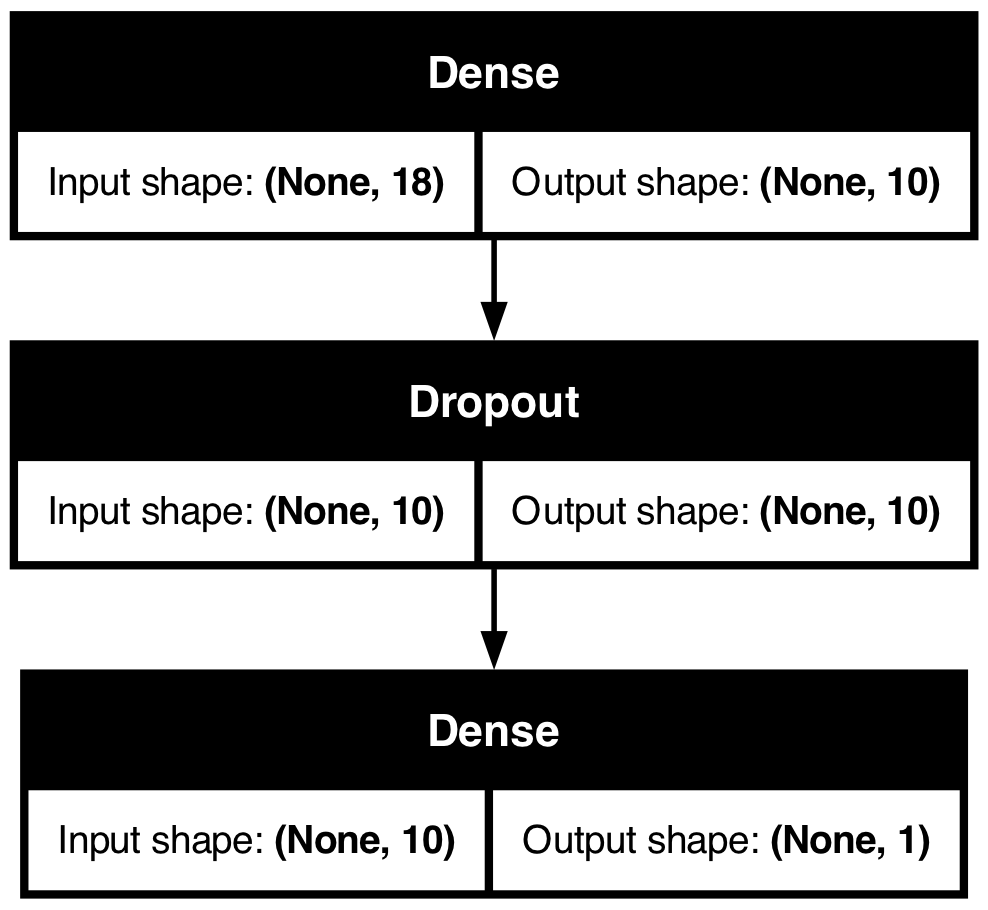

In [22]:
# show the model architecture
keras.utils.plot_model(model, show_shapes=True)

### Base Model Performance

In [23]:
# Fit the model to the training data and validate it using the validation set
history_nn_base = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=30,
    verbose=1,
    validation_data=(X_val, y_val)
)

# Predict probabilities for the validation data and convert them to binary outcomes using a threshold of 0.5
y_pred_nn_base = (model.predict(X_val) > 0.5).astype(int)

# Evaluate performance
print('Base model accuracy score: {0:0.4f}'.format(accuracy_score(y_val, y_pred_nn_base)))
print('Base model fbeta-score: {0:0.4f}'.format(fbeta_score(y_val, y_pred_nn_base, beta=2.0, zero_division=1)))
print('Base model f1-score: {0:0.4f}'.format(f1_score(y_val, y_pred_nn_base, zero_division=1)))
print('Base model AUC score: {0:0.4f}'.format(roc_auc_score(y_val, y_pred_nn_base))) 
print("\nConfusion Matrix: \n", confusion_matrix(y_val, y_pred_nn_base))
print("\nClassification Report: \n", classification_report(y_val, y_pred_nn_base, zero_division=1))

Epoch 1/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - fbeta_score: 0.8287 - loss: 0.6974 - val_fbeta_score: 0.9800 - val_loss: 0.6825
Epoch 2/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - fbeta_score: 0.8302 - loss: 0.6943 - val_fbeta_score: 0.9800 - val_loss: 0.6814
Epoch 3/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - fbeta_score: 0.8338 - loss: 0.6894 - val_fbeta_score: 0.9800 - val_loss: 0.6803
Epoch 4/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - fbeta_score: 0.8266 - loss: 0.6841 - val_fbeta_score: 0.9800 - val_loss: 0.6794
Epoch 5/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - fbeta_score: 0.8367 - loss: 0.6819 - val_fbeta_score: 0.9800 - val_loss: 0.6783
Epoch 6/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - fbeta_score: 0.8420 - loss: 0.6781 - val_fbeta_score: 0.9800 - val_loss: 0.6772
Epoch 7/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - fbeta_score: 0.8390 - loss: 0.6726 - val_fbeta_score: 0.9800 - val_loss: 0.6762
Epoch 8/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - fbeta_score: 0.8320 - l

### Use RandomSearchCV for hyperparameter tuning for Feedforward Neural Network

In [24]:
# Define hyperparameters for grid search
param_grid = {
    'model__dropout_rate': [0.0, 0.2, 0.4],
    'model__neurons': [10, 32, 64],
    'model__activation': ['relu', 'sigmoid', 'tanh'],
    'model__init_weights': ['uniform', 'normal', 'he_uniform'],
    'model__optimizer': ['SGD', 'RMSprop', 'Adam'],
    'model__learning_rate': [0.001, 0.01, 0.1],
}


model = KerasClassifier(model=define_model, epochs=10, batch_size=32)

# Perform a randomized search to find the best hyperparameters using cross-validation
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=100, cv=3, random_state=seed_num, verbose = 1)
# grid_search = RandomizedSearchCV(estimator=model, param_grid=param_grid, verbose = 1)
random_search_result = random_search.fit(X_train, y_train)

# Get the best model with the optimal hyperparameters from the random search
best_model_nn = random_search_result.best_estimator_

# Print the best model and its parameters
print("Best model chosen by GridSearchCV:")
print(best_model_nn)

best_params_nn = random_search_result.best_params_

# Print the best hyperparameters
print("\nBest hyperparameters found by GridSearchCV:")
print(best_params_nn)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
All parameters: 0.0 64 tanh he_uniform RMSprop 0.1 0.1
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - fbeta_score: 0.8365 - loss: 0.5456  
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - fbeta_score: 0.8074 - loss: 0.1532 
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - fbeta_score: 0.8449 - loss: 0.0330 
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - fbeta_score: 0.8316 - loss: 0.0049 
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - fbeta_score: 0.8404 - loss: 0.0037 
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - fbeta_score: 0.8375 - loss: 0.0014 
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - fbeta_score: 0.8276 - loss: 1.6422e-04 
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - fbeta_score: 0.8137 - loss: 7.3772e-05 
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - fbeta_score: 0.8261 - loss: 4.5256e-05 
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - fbeta_score: 0.8281 - lo

#### Performance of best model for Feedforward Neural Network

In [48]:
# train the model
best_model_nn.fit(X_train, y_train, batch_size=32, epochs=30, verbose=1, validation_data=(X_val, y_val))

# Make predictions on validation set
y_pred_nn_best = (best_model_nn.predict(X_val) > 0.5).astype(int)

# Compute and print accuracy score
print('Best model f1-score: {0:0.4f}'.format(f1_score(y_val, y_pred_nn_best)))
print('Best model fbeta-score: {0:0.4f}'.format(fbeta_score(y_val, y_pred_nn_best, beta=2.0)))
print('Best model accuray score: {0:0.4f}'.format(accuracy_score(y_val, y_pred_nn_best)))
print('Best model AUC score: {0:0.4f}'.format(roc_auc_score(y_val, y_pred_nn_best)))

All parameters: 0.2 64 relu he_uniform Adam 0.1 0.1
Epoch 1/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - fbeta_score: 0.9767 - loss: 0.6801 - val_fbeta_score: 0.9800 - val_loss: 0.3983
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - fbeta_score: 0.9836 - loss: 0.2820 - val_fbeta_score: 0.9800 - val_loss: 0.2620
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - fbeta_score: 0.9781 - loss: 0.2536 - val_fbeta_score: 0.9800 - val_loss: 0.2374
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - fbeta_score: 0.9797 - loss: 0.1841 - val_fbeta_score: 0.9800 - val_loss: 0.2335
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - fbeta_score: 0.9814 - loss: 0.1922 - val_fbeta_score: 0.9800 - val_loss: 0.3028
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - fbeta_score: 0.9832 - loss: 0.1888 - val_fbeta_score: 0.9800 - val_loss: 0.2084
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - fbeta_score: 0.9824 - loss: 0.1629 - val_fbeta_score: 0.9800 - val_loss: 0.2103
Epoch 8/30
12/12 ━━━━━━

### Evaluation
Report the accuracy, recall, precision and F1-score measures as well as the confusion matrix for a classification problem. <br>

In [26]:
y_pred_test_nn = (best_model_nn.predict(X_test) > 0.5).astype(int)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


Accuracy: 0.9722
Precision: 0.9709
Recall: 1.0000
F1-Score: 0.9852

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.62      0.77         8
           1       0.97      1.00      0.99       100

    accuracy                           0.97       108
   macro avg       0.99      0.81      0.88       108
weighted avg       0.97      0.97      0.97       108



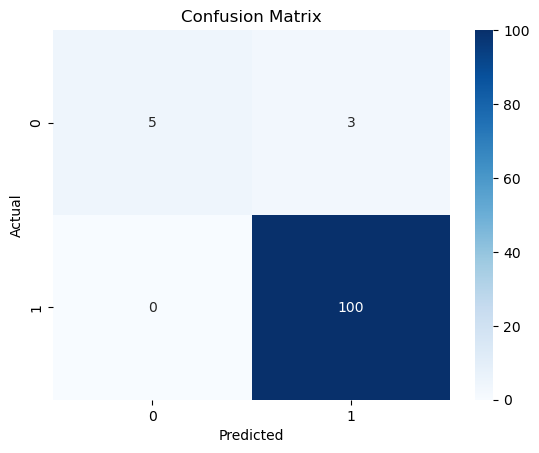

In [27]:
# evaluation metrics
accuracy_nn = accuracy_score(y_test, y_pred_test_nn)
precision_nn = precision_score(y_test, y_pred_test_nn, zero_division=0)
recall_nn = recall_score(y_test, y_pred_test_nn, zero_division=0)
f1_nn = f1_score(y_test, y_pred_test_nn, zero_division=0)

print(f"Accuracy: {accuracy_nn:.4f}")
print(f"Precision: {precision_nn:.4f}")
print(f"Recall: {recall_nn:.4f}")
print(f"F1-Score: {f1_nn:.4f}")

print("\nClassification Report:")
cr_nn = classification_report(y_test, y_pred_test_nn)
print(cr_nn)

cm_nn = confusion_matrix(y_test, y_pred_test_nn)
sns.heatmap(cm_nn, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Second model: Fuzzy Logic

Split the dataset again because in model 2, we are using different normalization process

In [28]:
X = df.drop(columns=['Run','Study','outcome'])
y = df['outcome']

In [29]:
target_classes = sorted(y.unique())

In [30]:
print(target_classes)

[0, 1]


#### Feature Selection

We perform feature selection before spliting the dataset into train, validation, and test set, with a default number of features selected, k is 8.

In [31]:
def feature_selection(X, y, k=8):
    """
    This function selects top k features based on a combined scoring method.
    First, each feature is evaluated using three different metrics, which are:
    1. F-test ANOVA
    2. Mutual Information
    3. Correlation with the target
    Then it combines the scores to rank the most important features.

    Input parameters:
    -----------------
    X: pd.DataFrame
        Feature set with shape (n_samples, n_features).
    y: pd.Series or array-like
        Target variable.
    k: integer, optional, default=8
        Number of top features to select.

    Returns:
    --------
    selected: list of str
        Names of the top k selected features.
    feature_scores : pd.DataFrame
        DataFrame showing each feature's F-score, Mutual Info score, correlation,
        and combined score, sorted by `Combined_Score` in descending order.
        
    """

    # F-test feature selection
    selector_f = SelectKBest(score_func=f_classif, k=k)
    selector_f.fit(X, y)
    f_scores = selector_f.scores_

    # Mutual Information
    selector_mi = SelectKBest(score_func=mutual_info_classif, k=k)
    selector_mi.fit(X, y)
    mi_scores = selector_mi.scores_

    # Pearson correlation
    correlations = abs(X.corrwith(y))

    # Combine scores= scale correlation * 100 to match score magnitudes
    feature_scores = pd.DataFrame({
        'Feature': X.columns,
        'F_Score': f_scores,
        'MI_Score': mi_scores,
        'Correlation': correlations.values,
        'Combined_Score': (f_scores + mi_scores + correlations.values * 100) / 3
    }).sort_values('Combined_Score', ascending=False)

    # Select top-k features based on the combined score
    selected_features = feature_scores.head(k)['Feature'].tolist()
    
    print(f"There are {feature_scores.shape[0]} features in total, top {k} is used.")
    print(f"Selected features:\n{selected_features}")

    return selected_features, feature_scores

In [32]:
selected_features, feature_scores = feature_selection(X, y)

There are 18 features in total, top 8 is used.
Selected features:
['vconst_corr', 'vconst_2', 'convect_corr', 'bckgrnd_vdc1', 'bckgrnd_vdc_eq', 'vconst_4', 'bckgrnd_vdc_psim', 'vconst_5']


In [33]:
seed_num = 10

# Split the dataset into 70% training and 30% temporary data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=seed_num)

# Second split into 10% validation and 20% test data
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=(2/3), random_state=seed_num)
print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

Training set: (378, 18)
Validation set: (54, 18)
Test set: (108, 18)


#### Feature normalization

In [34]:
def normalize_features(X_train, X_test):
    """
    This function normalizes features using QuantileTransformer in sklearn by transforming
    feature distributions to a uniform distribution in [0, 1]. Then, it scales all values
    to range [0, 10].

    Input parameters:
    -----------------
    X_train: pd.DataFrame
        Training feature set.
    X_test: pd.DataFrame
        Testing feature set.

    Returns:
    --------
    X_train_norm : pd.DataFrame
        Normalized training features scaled to [0, 10].
    X_test_norm : pd.DataFrame
        Normalized testing features scaled to [0, 10].

    """
    # Initialize the QuantileTransformer with uniform output
    qt = QuantileTransformer(output_distribution='uniform', random_state=0)

    # Fit the transformer on training data and apply transformation
    X_train_norm = qt.fit_transform(X_train)

    # Apply the same transformation to the test data
    X_test_norm = qt.transform(X_test)

    # Scale the normalized values from [0, 1] to [0, 10]
    X_train_norm *= 10
    X_test_norm *= 10

    return pd.DataFrame(X_train_norm, columns=X_train.columns), pd.DataFrame(X_test_norm, columns=X_test.columns)

In [35]:
X_train_norm, X_val_norm = normalize_features(X_train, X_val)
_, X_test_norm = normalize_features(X_train, X_test)

#### Create fuzzy variables and rules

In [36]:
def create_fuzzy_variables(X_train, feature_names, target_classes):
    """
    Create fuzzy logic variables, antecedents and consequent from training data.
    
    Input parameters:
    -----------------
    X_train: pd.DataFrame
        Training dataset that contains selected features.
    feature_names: list of str
        selected_features returned from function feature_selection
    target_classes: list
        List of class labels [0, 1].
        
    Returns:
    --------
    antecedents: dict
        Dictionary of fuzzy input objects for each feature.
    consequent: skfuzzy.control.Consequent
        Fuzzy output variable representing the predicted class.
    
    """
    antecedents = {}
    
    for f in feature_names:
        # Range of input feature based on its min and max
        lo = X_train[f].min()
        hi = X_train[f].max()
        mid = (lo + hi) / 2
        
        # Create antecedent with 100 resolution points
        antecedents[f] = ctrl.Antecedent(np.linspace(lo, hi, 100), f)
        
        # Triangular membership functions: low, medium, and high
        antecedents[f]['low'] = fuzz.trimf(antecedents[f].universe, [lo, lo, mid])
        antecedents[f]['medium'] = fuzz.trimf(antecedents[f].universe, [lo, mid, hi])
        antecedents[f]['high'] = fuzz.trimf(antecedents[f].universe, [mid, hi, hi])
        
    # Define consequent for binary classification. Range: [0,2) with 0.1 step for smooth transitions
    consequent = ctrl.Consequent(np.arange(0, 2, 0.1), 'outcome')
    # Define membership functions for output labels
    consequent['negative'] = fuzz.trimf(consequent.universe, [0, 0, 0.6])
    consequent['positive'] = fuzz.trimf(consequent.universe, [0.4, 1, 1])

    return antecedents, consequent

In [37]:
def generate_fuzzy_rules(antecedents, consequent, feature_names, target_classes, max_rules=25):
    """
    This function generate a set of fuzzy logic rules for classification using:
    1. Individual feature-based rules
    2. Two-feature combination
    3. Optional three-feature combination
    
    Input paramteres:
    -----------
    antecendents: dict
        Dictionary of fuzzy input variables (from function create_fuzzy_variables)
    consequent: skfuzzy.control.Consequent
        Fuzzy output variable representing the predicted class.
    feature_names: list of str (from function create_fuzzy_variables)
        List of selected feature names used to generate rules.
    target_classes: list
        List of class labels [0, 1]
    max_rules: integer, optional, default=25
        Maximum number of rules to generate to limit system complexity.
    
    Returns:
    --------
    rules: list of skfuzzy.control.Rule
        A list of generated fuzzy rules to be passed into control system.
    
    """
    
    rules = []      # lists to hold fuzzy rules 
    rule_count = 0  # to count the number of rules

    fuzzy_levels = ['low', 'medium', 'high']

    # Individual feature-based rules
    for feature in feature_names:
        if rule_count >= max_rules:
            break
        # IF feature is low, THEN outcome is negative
        rules.append(ctrl.Rule(antecedents[feature]['low'], consequent['negative']))
        print(f"Rule {rule_count + 1}: IF {feature} is low THEN outcome is negative")
        rule_count += 1

        if rule_count >= max_rules:
            break
            
        # IF feature is high, THEN outcome is positive
        rules.append(ctrl.Rule(antecedents[feature]['high'], consequent['positive']))
        print(f"Rule {rule_count + 1}: IF {feature} is high THEN outcome is positive")
        rule_count += 1

        if rule_count >= max_rules:
            break
            
        # IF feature is medium, THEN outcome is negative
        rules.append(ctrl.Rule(antecedents[feature]['medium'], consequent['negative']))
        print(f"Rule {rule_count + 1}: IF {feature} is medium THEN outcome is negative")
        rule_count += 1

    # Two-feature combination
    if len(feature_names) >= 2:
        for f1, f2 in itertools.combinations(feature_names, 2):
            if rule_count >= max_rules:
                break
            # IF both features are high, THEN outcome is positive
            rules.append(ctrl.Rule(antecedents[f1]['high'] & antecedents[f2]['high'], consequent['positive']))
            print(f"Rule {rule_count + 1}: IF {f1} is high AND {f2} is high THEN outcome is positive")
            rule_count += 1
            
            if rule_count >= max_rules:
                break
            # IF both features are low, THEN outcome is negative
            rules.append(ctrl.Rule(antecedents[f1]['low'] & antecedents[f2]['low'], consequent['negative']))
            print(f"Rule {rule_count + 1}: IF {f1} is low AND {f2} is low THEN outcome is negative")
            rule_count += 1

    # Optional three-feature combination
    if len(feature_names) >= 3:
        for f1, f2, f3 in itertools.combinations(feature_names[:4], 3):  # Limit top 4 for speed
            if rule_count >= max_rules:
                break
            # IF all three features are high, THEN outcome is positive
            rules.append(ctrl.Rule(
                antecedents[f1]['high'] & antecedents[f2]['high'] & antecedents[f3]['high'],
                consequent['positive']
            ))
            print(f"Rule {rule_count + 1}: IF {f1}, {f2}, {f3} are high THEN outcome is positive")
            rule_count += 1
    print("--------------------------------------------------------------------------")
    print(f"\nTotal rules generated: {len(rules)}")
    return rules

In [38]:
antecedents, consequent = create_fuzzy_variables(X_train_norm[selected_features], selected_features, target_classes)
rules = generate_fuzzy_rules(antecedents, consequent, selected_features, target_classes, max_rules=25)

Rule 1: IF vconst_corr is low THEN outcome is negative
Rule 2: IF vconst_corr is high THEN outcome is positive
Rule 3: IF vconst_corr is medium THEN outcome is negative
Rule 4: IF vconst_2 is low THEN outcome is negative
Rule 5: IF vconst_2 is high THEN outcome is positive
Rule 6: IF vconst_2 is medium THEN outcome is negative
Rule 7: IF convect_corr is low THEN outcome is negative
Rule 8: IF convect_corr is high THEN outcome is positive
Rule 9: IF convect_corr is medium THEN outcome is negative
Rule 10: IF bckgrnd_vdc1 is low THEN outcome is negative
Rule 11: IF bckgrnd_vdc1 is high THEN outcome is positive
Rule 12: IF bckgrnd_vdc1 is medium THEN outcome is negative
Rule 13: IF bckgrnd_vdc_eq is low THEN outcome is negative
Rule 14: IF bckgrnd_vdc_eq is high THEN outcome is positive
Rule 15: IF bckgrnd_vdc_eq is medium THEN outcome is negative
Rule 16: IF vconst_4 is low THEN outcome is negative
Rule 17: IF vconst_4 is high THEN outcome is positive
Rule 18: IF vconst_4 is medium THEN 

#### Mamdani Fuzzy Inference System

In [39]:
class MamdaniFISClassifier(BaseEstimator, ClassifierMixin):
    """
    Mamdani Fuzzy Inference System (FIS).

    Input parameters:
    -----------------
    system : skfuzzy.control.ControlSystem
        The fuzzy logic control system containing defined rules and variables.
    threshold : float, optional, default=0.5
        Decision threshold for converting fuzzy output to binary classification.
    cols : list of str, optional
        Names of input features, required if X has no column names.

    Attributes:
    -----------
    inputs_ : list of str
        Stores the feature names used during fitting.
    """
    def __init__(self, system, threshold=0.5, cols=None):
        self.system = system
        self.threshold = threshold
        self.cols = cols

    def fit(self, X, y=None):
        self.inputs_ = X.columns.tolist() if hasattr(X, 'columns') else self.cols
        return self

    def _risk_score(self, row_dict):
        # compute the fuzzy outcome of a single row
        sim = ctrl.ControlSystemSimulation(self.system, flush_after_run=1)
        for name, val in row_dict.items():
            sim.input[name] = val
        sim.compute()
        return sim.output['outcome']

    def predict(self, X):
        # predict the labels based on the fuzzy system's output and threshold
        rows = X.to_dict(orient='records') if hasattr(X, 'iterrows') else [dict(zip(self.inputs_, X[i, :])) for i in range(X.shape[0])]
        proba = np.array([self._risk_score(r) for r in rows])
        return (proba >= self.threshold).astype(int)

    def predict_proba(self, X):
        # predict class probabilities from fuzzy outcomes
        rows = X.to_dict(orient='records') if hasattr(X, 'iterrows') else [dict(zip(self.inputs_, X[i, :])) for i in range(X.shape[0])]
        proba = np.array([self._risk_score(r) for r in rows])
        return np.vstack([1 - proba, proba]).T

In [40]:
# Search best threshold
thr_grid = np.linspace(0.1, 0.5, 9) # define range of threshold values to test

best_acc = 0        # best accuracy 
best_model = None   # pipeline object of best-performing model
best_thr = None     # threshold of best accuracy


for thr in thr_grid:
    # create a new fuzzy control system for each threshold
    system = ctrl.ControlSystem(rules)
    #initialize Mamdani FIS Classifier with current threshold
    fis = MamdaniFISClassifier(system, threshold=thr, cols=selected_features)
    
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("fis", fis)
    ])
    
    # train pipeline using normalized training data
    pipe.fit(X_train_norm[selected_features], y_train)
    # predict using normalized test data
    y_pred = pipe.predict(X_test_norm[selected_features])
    
    # calculate classification accuracy
    acc = accuracy_score(y_test, y_pred)

    if acc > best_acc:
        best_acc = acc
        best_model = pipe
        best_thr = thr

print(f"\nBest fuzzy system: threshold = {best_thr:.2f}, accuracy = {best_acc:.4f}")



Best fuzzy system: threshold = 0.10, accuracy = 0.9259


#### Model Prediction & Evaluation

In [41]:
final_fis = best_model.named_steps["fis"]
y_pred = best_model.predict(X_test_norm[selected_features])
proba = final_fis.predict_proba(X_test_norm[selected_features])[:, 1]

Accuracy: 0.9259
Precision: 0.9259
Recall: 1.0000
F1-Score: 0.9615

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.93      1.00      0.96       100

    accuracy                           0.93       108
   macro avg       0.46      0.50      0.48       108
weighted avg       0.86      0.93      0.89       108



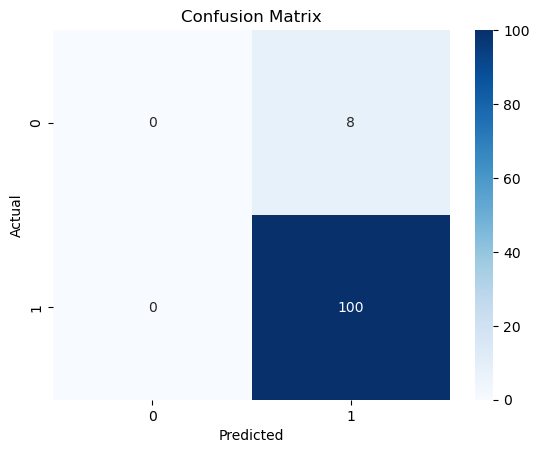

In [42]:
# evaluation metrics
accuracy_fl = accuracy_score(y_test, y_pred)
precision_fl = precision_score(y_test, y_pred, zero_division=0)
recall_fl = recall_score(y_test, y_pred, zero_division=0)
f1_fl = f1_score(y_test, y_pred, zero_division=0)

print(f"Accuracy: {accuracy_fl:.4f}")
print(f"Precision: {precision_fl:.4f}")
print(f"Recall: {recall_fl:.4f}")
print(f"F1-Score: {f1_fl:.4f}")

print("\nClassification Report:")
cr_fl = classification_report(y_test, y_pred)
print(cr_fl)

cm_fl = confusion_matrix(y_test, y_pred)
sns.heatmap(cm_fl, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

#### Visualize membership functions

In [43]:
def plot_fuzzy_membership_functions(antecedents, consequent, feature_names):
    """
    This function plot fuzzy membership functions for each antecedent 
    and the consequent variable.

    Input parameters:
    -----------
    antecedents: dict
        Dictionary of fuzzy Antecedent variables
    consequent: skfuzzy.control.Consequent
        The fuzzy output variable.
    feature_names : list of str
        List of feature names to visualize membership functions.

    """
    for feature in feature_names:
        plt.figure(figsize=(6, 3))
        antecedents[feature].view()
        plt.title(f'Membership Functions for {feature}')
        plt.tight_layout()
        plt.show()

    # Plot consequent
    plt.figure(figsize=(6, 3))
    consequent.view()
    plt.title('Output Membership Functions')
    plt.tight_layout()
    plt.show()

<Figure size 600x300 with 0 Axes>

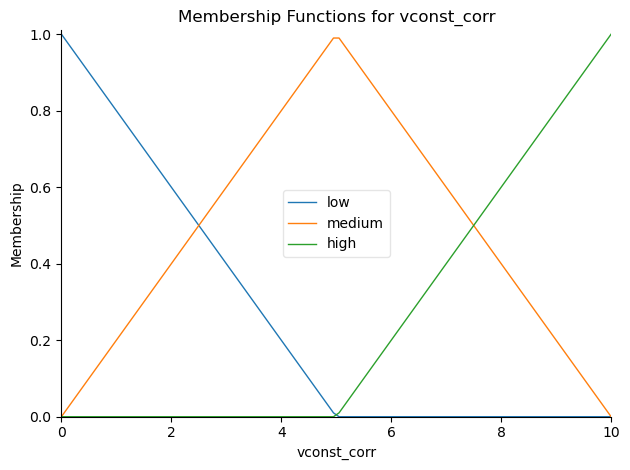

<Figure size 600x300 with 0 Axes>

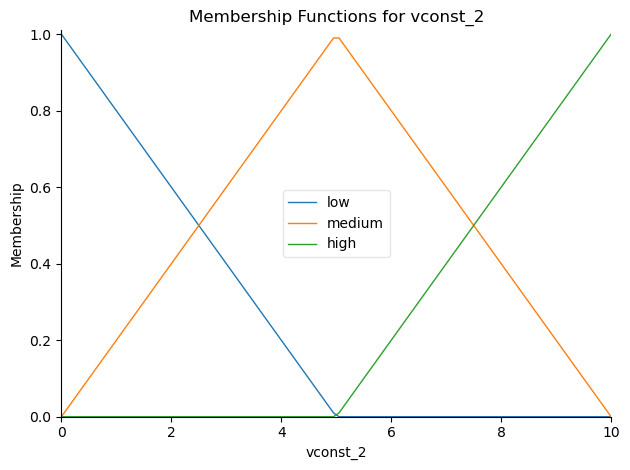

<Figure size 600x300 with 0 Axes>

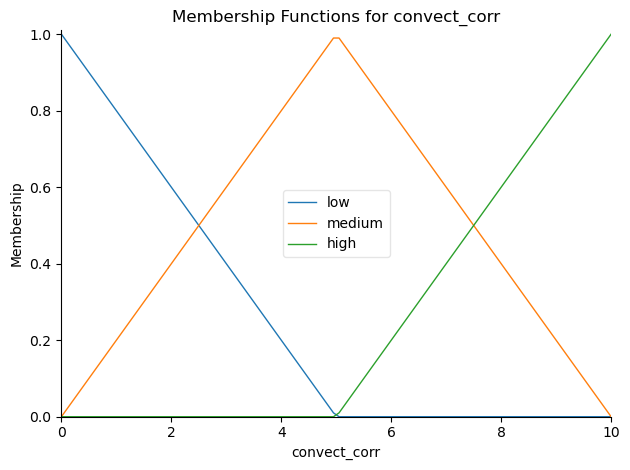

<Figure size 600x300 with 0 Axes>

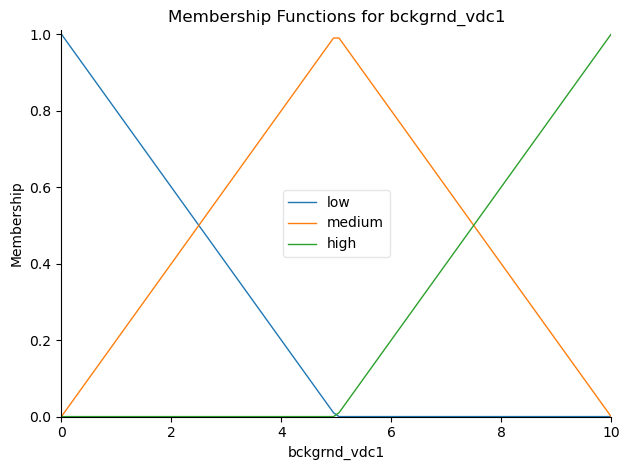

<Figure size 600x300 with 0 Axes>

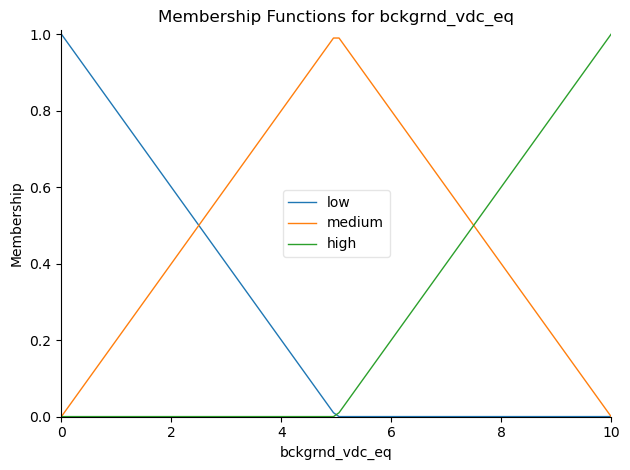

<Figure size 600x300 with 0 Axes>

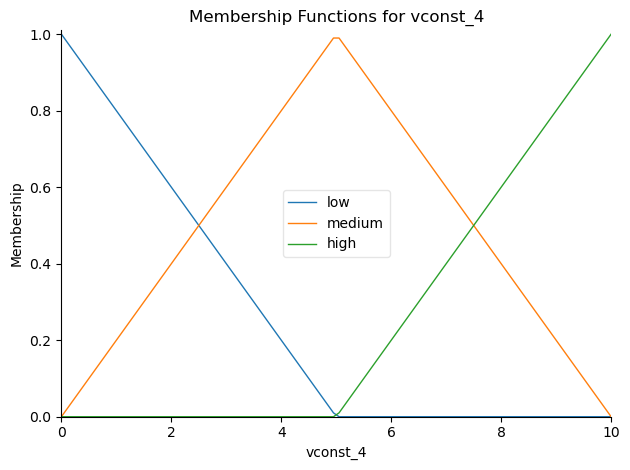

<Figure size 600x300 with 0 Axes>

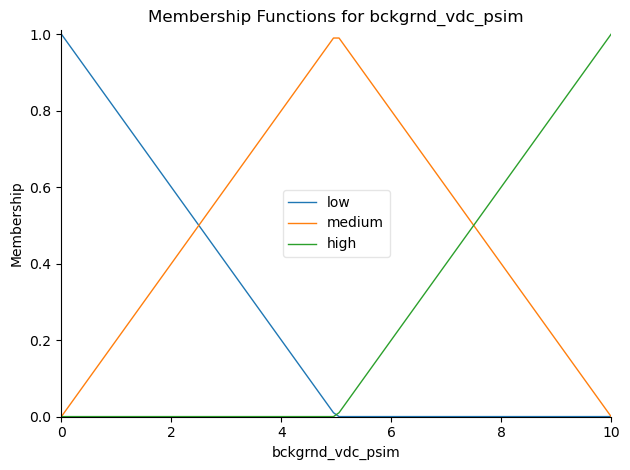

<Figure size 600x300 with 0 Axes>

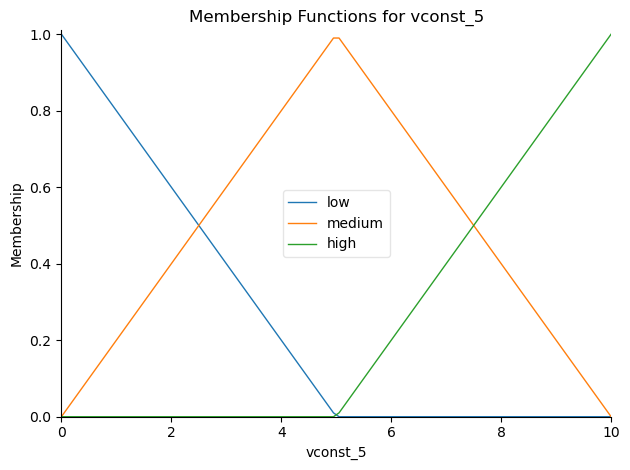

<Figure size 600x300 with 0 Axes>

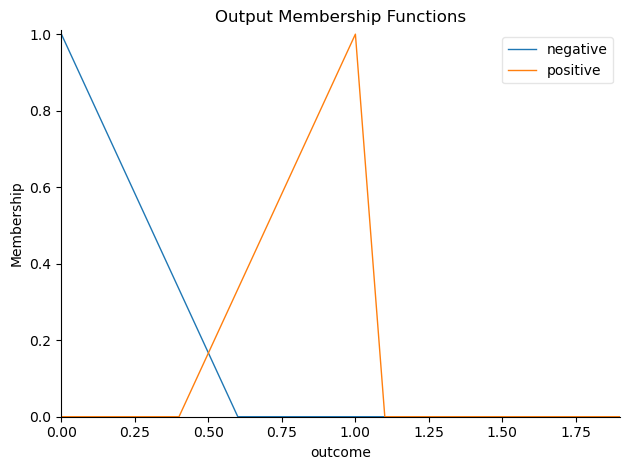

In [44]:
plot_fuzzy_membership_functions(antecedents, consequent, selected_features)

### Comparison

In [45]:
comparison = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1-score"],
    "Neural Network": [accuracy_nn, precision_nn, recall_nn, f1_nn],
    "Fuzzy Logic": [accuracy_fl, precision_fl, recall_fl, f1_fl]
})

In [46]:
comparison

,Metric,Neural Network,Fuzzy Logic
0,Accuracy,0.972222,0.925926
1,Precision,0.970874,0.925926
2,Recall,1.000000,1.000000
3,F1-score,0.985222,0.961538


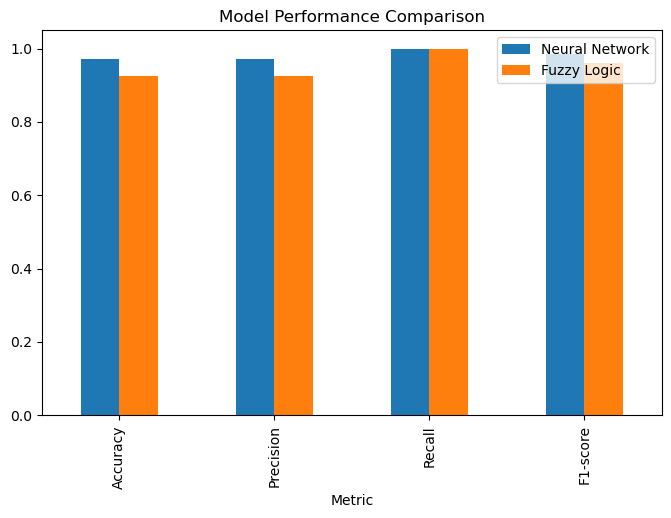

In [47]:
#visualize the comparison
comparison.set_index("Metric").plot(kind="bar", figsize=(8, 5), title="Model Performance Comparison")
plt.show()

Based on the evaluation metrics, the Neural Network model performs better than the Fuzzy Logic model across the metrics used. 
- Accuracy: Neural Network achieves higher accuracy which is 97.22% compared to Fuzzy Logic which is 92.59%. This indicates that the Neural Network makes more correct predictions overall.
- Precision: Neural Network also outperforms in precision, with 97.09% vs. 92.59% in Fuzzy Logic. In prediction of positive outcome, Neural Network is more likely to predict it correctly compared to Fuzzy Logic.
- Recall: Both models achieve perfect recall which is 100%, that means they are equally effective in identifying all positive instances in the climate dataset.
- F1-score: In F1-score, Neural Network also has a higher F1-score than the Fuzzy Logic, suggesting that Neural Network provides better overall balance between precision and recall.  

Therefore, we can conclude that the Neural Network model is more precise and balanced in this binary classification task because it consistently outperforms the Fuzzy Logic model in accuracy, precision, and F1-score, and both models are equally good at F1-score. However, the choice of model is dependent on the domain context and application requirement, and combining both models in a hybrid system could leverage their strengths and might achieve better results. 
